In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

In [4]:
#Read highest offer and transaction history
price = pd.read_csv('trait_data_file_with_offer_name.csv')

#Read traits
trait = pd.read_csv('trait_data_file_with_name.csv') 

In [5]:
def count_type(x):
    '''
    count the number of element in a trait
    return dictionary
    '''
    trait_count = dict()
    trait_dict = dict()
    for column in x:
        if column != 'ID':
            trait_count[column] = len(np.unique(x[column]))
            trait_dict[column] = np.unique(x[column])
    return trait_count, trait_dict

traits_count,traits_detail = count_type(trait)

In [6]:
print(traits_count)
print()
print('Total number of different element:', sum(traits_count.values()))

{'Background': 8, 'Fur': 19, 'Mouth': 33, 'Eyes': 23, 'Earring': 7, 'Clothes': 44, 'Hat': 37}

Total number of different element: 171


In [7]:
for key,value in traits_detail.items():
    print(key+':',value)
    print('\n')

Background: ['Aquamarine' 'Army Green' 'Blue' 'Gray' 'New Punk Blue' 'Orange' 'Purple'
 'Yellow']


Fur: ['Black' 'Blue' 'Brown' 'Cheetah' 'Cream' 'Dark Brown' 'Death Bot' 'Dmt'
 'Golden Brown' 'Gray' 'Noise' 'Pink' 'Red' 'Robot' 'Solid Gold' 'Tan'
 'Trippy' 'White' 'Zombie']


Mouth: ['Bored' 'Bored Bubblegum' 'Bored Cigar' 'Bored Cigarette' 'Bored Dagger'
 'Bored Kazoo' 'Bored Party Horn' 'Bored Pipe' 'Bored Pizza'
 'Bored Unshaven' 'Bored Unshaven Bubblegum' 'Bored Unshaven Cigar'
 'Bored Unshaven Cigarette' 'Bored Unshaven Dagger' 'Bored Unshaven Kazoo'
 'Bored Unshaven Party horn' 'Bored Unshaven Pipe' 'Bored Unshaven Pizza'
 'Discomfort' 'Dumbfounded' 'Grin' 'Grin Diamond Grill' 'Grin Gold Grill'
 'Grin Multicolored' 'Jovial' 'Phoneme  ooo' 'Phoneme L' 'Phoneme Oh'
 'Phoneme Vuh' 'Phoneme Wah' 'Rage' 'Small Grin' 'Tongue Out']


Eyes: ['3d' 'Angry' 'Blindfold' 'Bloodshot' 'Blue Beams' 'Bored' 'Closed'
 'Coins' 'Crazy' 'Cyborg' 'Eyepatch' 'Heart' 'Holographic' 'Hypnotized'
 'Laser

In [8]:
trans = (price.fillna(-1)).loc[:,'trans1':'trans13'].to_numpy()

def most_recent_transaction(x):
    '''
    return a numpy array with the most recent transaction of each Ape
    if an Ape was never sold, set the value to -1
    '''
    current = []
    for i in range(trans.shape[0]):
        if -1 in trans[i]:
            a = np.where(trans[i] == -1)
            ind = a[0][0]
            if ind == 0:
                current.append(-1)
            else: 
                current.append(trans[i][ind-1])
        else:
            current.append(trans[i][-1])
    
    current = np.array(current)
    current = np.where(current == 0, 0.001, current)
    return current   

recent_trans = most_recent_transaction(trans)

## OnehotEncoder 
x: onehot traits + offer price, label: most recent transcation price

In [9]:
x = trait.to_numpy()[:,1:]

OH_enc = OneHotEncoder().fit(x)
x = OH_enc.transform(x).toarray()

df_OH = pd.DataFrame(x)
df_OH['Offer'] = price['Offer']
df_OH['trans'] = recent_trans

In [10]:
#Split the data set by sold 0 times and others
df_sold_oh = df_OH[df_OH['trans'] != -1]
df_never_oh = df_OH[df_OH['trans'] == -1]

In [11]:
#label value: transaction 
x_oh = df_sold_oh.to_numpy()[:,:-1]
y_oh = df_sold_oh.to_numpy()[:,-1]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x_oh, y_oh, test_size=0.25, random_state=42)

In [13]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

In [14]:
rf_oh = RandomForestRegressor(n_estimators = 300, max_depth = 50,min_samples_split = 2, min_samples_leaf = 1)

In [15]:
rf_oh.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [16]:
acc = evaluate(rf_oh,X_test,y_test)

Model Performance
Average Error: 15.8312 degrees.
Accuracy = 75.11%.


In [17]:
y_pred_oh = rf_oh.predict(X_test)

Text(0.5, 1.0, 'Most Recent Transaction')

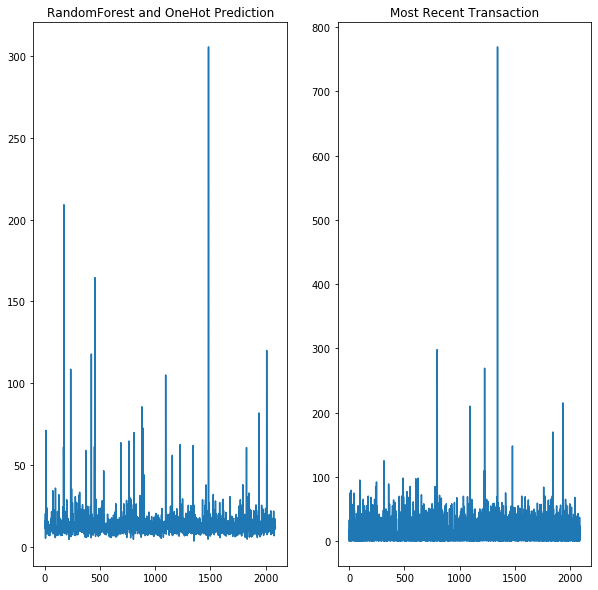

In [18]:
x_axis = np.arange(len(y_test))
fig = plt.figure(figsize = (10,10))
fig.add_subplot(1,2,1)
plt.plot(x_axis,y_pred_oh)
plt.title('RandomForest and OneHot Prediction')

fig.add_subplot(1,2,2)
plt.plot(x_axis,y_test)
plt.title('Most Recent Transaction')


In [19]:
def importance(x,dic):
    importance = dict()
    start = 0
    for key,value in dic.items():
        importance[key] = sum(x[start:start+value])*100
        start += value
    return importance

In [20]:
importance = importance(rf_oh.feature_importances_,traits_count)

In [21]:
labels = list(importance.keys())
sizes = list(importance.values())
explode = [(0.5 if label == 'Earring'else 0) for label in labels]

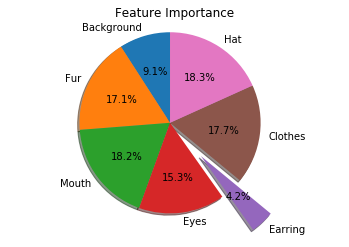

In [22]:
fig1, ax1 = plt.subplots()
ax1.pie(sizes,explode = explode,labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Feature Importance')
plt.show()